In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io

In [2]:
img_base_url = "https://yoyoyo-yo.github.io/Gasyori100knock/"

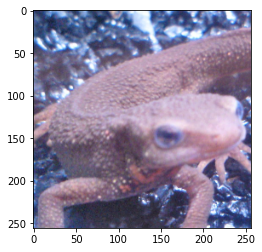

In [3]:
img_orig = io.imread(img_base_url + "dataset/images/imori_256x256.png")
plt.imshow(img_orig)

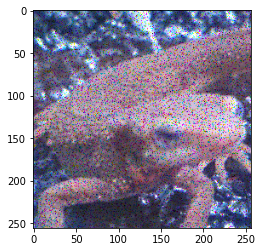

In [4]:
img_noise_orig = io.imread(img_base_url + 'dataset/images/imori_256x256_noise.png')
plt.imshow(img_noise_orig)

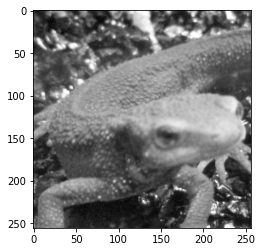

In [5]:
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
plt.imshow(img_gray, cmap='gray')

### 余談
`matplotlib`の`imshow`はデフォルトで`virdis`というカラーマップを使うため、青緑っぽく表示される。

また、グレースケールは正規化されている。

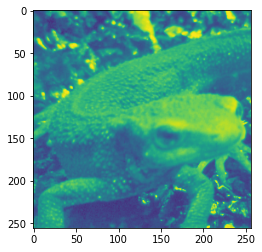

In [80]:
from matplotlib.colors import NoNorm
plt.imshow(img_gray, norm=NoNorm())

## Question 11 平滑化フィルタ Smoothing filter

ノイズ画像に対して、平滑化フィルタ(5x5)をかけよ。

平滑化フィルタはフィルタ内の画素の平均値を出力するフィルタである。

In [82]:
def smooth_filter(img, kernel_size=(3, 3)):
    # Padding
    h, w = img.shape[0:2]
    kernel_h, kernel_w = kernel_size
    
    top_pad = int(((kernel_h + 1) / 2))
    bottom_pad = top_pad
    left_pad = int(((kernel_w + 1) / 2))
    right_pad = left_pad
    _img = np.pad(img, ((top_pad, bottom_pad), (left_pad, right_pad), (0, 0)))

    out = np.zeros_like(_img)
    new_h, new_w = _img.shape[0:2]
    c = 1 if len(out.shape) == 2 else out.shape[2]
    
    for i in range(kernel_h // 2, new_h - kernel_h // 2):
        for j in range(kernel_w // 2, new_w - kernel_w // 2):
            for k in range(c):
                out[i, j, k] = np.mean(_img[i - kernel_h//2:i + kernel_h//2 + 1, j - kernel_w//2:j + kernel_w//2 + 1, k])

    return out[top_pad:top_pad + h, left_pad:left_pad + w].astype(np.uint8)

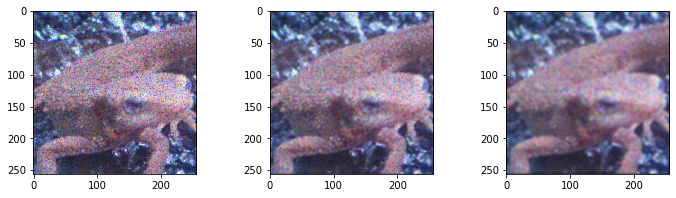

In [84]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.imshow(img_noise_orig)
plt.subplot(1, 3, 2)
plt.imshow(smooth_filter(img_noise_orig, (3, 3)))
plt.subplot(1, 3, 3)
plt.imshow(smooth_filter(img_noise_orig, (5, 5)))
plt.show()

## Question 12 モーションフィルタ Motion filter

モーションフィルタ(5x5)を実装せよ。

モーションフィルタとは対角方向の平均値を取るフィルタであり、k x kのフィルタは次式で定義される。

![](https://github.com/yoyoyo-yo/Gasyori100knock/raw/master/questions/question_11_20/images/motion_filter_equ.png)

In [93]:
def gen_motion_kernel(k_size=(3, 3)):
    kernel = np.zeros(k_size)
    kernel[range(k_size[0]), range(k_size[0])] = 1 / k_size[0]
    return kernel

In [294]:
def motion_filter(img, kernel_size=(3, 3)):
    # Padding
    h, w = img.shape[0:2]
    kernel_h, kernel_w = kernel_size
    
    top_pad = int(((kernel_h + 1) / 2))
    bottom_pad = top_pad
    left_pad = int(((kernel_w + 1) / 2))
    right_pad = left_pad
    _img = np.pad(img, ((top_pad, bottom_pad), (left_pad, right_pad), (0, 0)))

    out = np.zeros_like(_img)
    new_h, new_w = _img.shape[0:2]
    c = 1 if len(out.shape) == 2 else out.shape[2]
    
    kernel = gen_motion_kernel(kernel_size)
    
    for i in range(kernel_h // 2, new_h - kernel_h // 2):
        for j in range(kernel_w // 2, new_w - kernel_w // 2):
            for k in range(c):
                out[i, j, k] = np.sum(_img[i - kernel_h//2:i + kernel_h//2 + 1, j - kernel_w//2:j + kernel_w//2 + 1, k] * kernel)

    return out[top_pad:top_pad + h, left_pad:left_pad + w].astype(np.uint8)

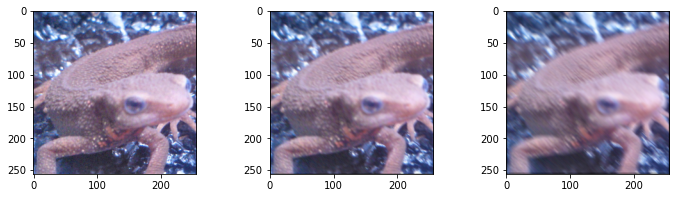

In [99]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.imshow(img_orig)
plt.subplot(1, 3, 2)
plt.imshow(motion_filter(img_orig, (3, 3)))
plt.subplot(1, 3, 3)
plt.imshow(motion_filter(img_orig, (7, 7)))
plt.show()

## Question 13 Max-Minフィルタ Max-Min filter

グレースケールに対してMAX-MINフィルタ(3x3)を実装せよ。

MAX-MINフィルタとはフィルタ内の画素の最大値と最小値の差を出力するフィルタであり、エッジ検出のフィルタの一つである。

エッジ検出とは画像内の線を検出るすることであり、このような画像内の情報を抜き出す操作を特徴抽出と呼ぶ。

エッジ検出では多くの場合、グレースケール画像に対してフィルタリングを行う。

In [130]:
def max_min_filter(img, kernel_size=(3, 3)):
    # Padding
    _img = img.copy().astype(np.float32)
    
    h, w = img.shape[0:2]
    kernel_h, kernel_w = kernel_size
    
    top_pad = int(((kernel_h + 1) / 2))
    bottom_pad = top_pad
    left_pad = int(((kernel_w + 1) / 2))
    right_pad = left_pad
    
    if len(_img.shape) == 2:
        _img = np.expand_dims(_img, axis=-1)
    
    _img = np.pad(_img, [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)], 'edge')

    out = np.zeros_like(_img)
    new_h, new_w = _img.shape[0:2]
    c = 1 if len(out.shape) == 2 else out.shape[2]
        
    for i in range(kernel_h // 2, new_h - kernel_h // 2):
        for j in range(kernel_w // 2, new_w - kernel_w // 2):
            for k in range(c):
                out[i, j, k] = _img[i - kernel_h//2:i + kernel_h//2 + 1, j - kernel_w//2:j + kernel_w//2 + 1, k].max() - _img[i - kernel_h//2:i + kernel_h//2 + 1, j - kernel_w//2:j + kernel_w//2 + 1, k].min()

    return out[top_pad:top_pad + h, left_pad:left_pad + w].astype(np.uint8)

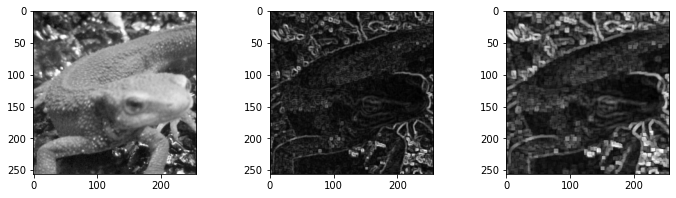

In [132]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.imshow(img_gray, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(max_min_filter(img_gray, (3, 3)), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(max_min_filter(img_gray, (5, 5)), cmap='gray')
plt.show()

## Question 14 微分フィルタ Differential filter

グレースケールに対して、微分フィルタ(3x3)を実装せよ。

微分フィルタは輝度の急激な変化が起こっている部分のエッジを取り出すフィルタであり、隣り合う画素同士の差を取る。赤線のR成分を取り出すと輪郭や、目の境目など色が変わる部分でR値が急激に変化している。この部分がエッジとなる。

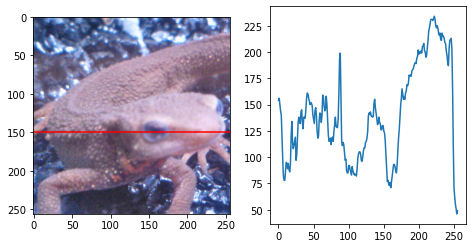

In [133]:
_w = img_orig.shape[1]
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.imshow(img_orig); plt.plot(np.arange(_w), [150] * _w, color='red')
plt.subplot(1, 3, 2); plt.plot(np.arange(_w), img_orig[150, :, 0])
plt.show()

![](https://github.com/yoyoyo-yo/Gasyori100knock/raw/master/questions/question_11_20/images/diff_filter_equ.png)

In [314]:
def gen_diff_kernel(type='x'):
    if type == 'y':
        return np.array([[0, -1, 0], [0, 1, 0], [0, 0, 0]])
    else:
        return np.array([[0, 0, 0], [-1, 1, 0], [0, 0, 0]])

In [324]:
def diff_filter(img, type='x', kernel_size=(3, 3)):
    # Padding
    _img = img.copy().astype(np.float32)

    
    h, w = img.shape[0:2]
    kernel_h, kernel_w = kernel_size
    
    top_pad = int(((kernel_h + 1) / 2))
    bottom_pad = top_pad
    left_pad = int(((kernel_w + 1) / 2))
    right_pad = left_pad
    
    if len(_img.shape) == 2:
        _img = np.expand_dims(_img, axis=-1)
    
    _img = np.pad(_img, ((top_pad, bottom_pad), (left_pad, right_pad), (0, 0)))

    out = np.zeros_like(_img)
    new_h, new_w = _img.shape[0:2]
    c = 1 if len(out.shape) == 2 else out.shape[2]
    
    kernel = gen_diff_kernel(type)
        
    for i in range(kernel_h // 2, new_h - kernel_h // 2):
        for j in range(kernel_w // 2, new_w - kernel_w // 2):
            for k in range(c):
                out[i, j, k] = np.sum(_img[i - kernel_h//2:i + kernel_h//2 + 1, j - kernel_w//2:j + kernel_w//2 + 1, k] * kernel)

    # if converted to uint8 without clip, cannot handle negative numbers
    return np.clip(out[top_pad:top_pad + h, left_pad:left_pad + w], 0, 255).astype(np.uint8)

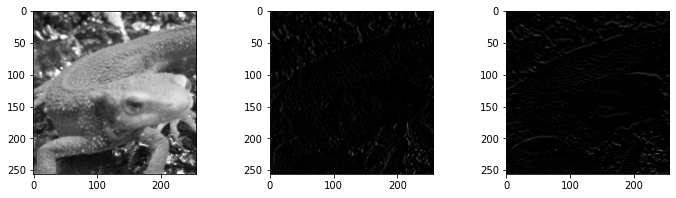

In [316]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.imshow(img_gray, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(diff_filter(img_gray), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(diff_filter(img_gray, type='y'), cmap='gray')
plt.show()

## Question 15 プリューウィットフィルタ Prewitt filter

グレースケールに対して、Prewittフィルタ(5x5)を実装せよ。

Prewitt(プレウィット)フィルタはエッジ抽出フィルタの一種であり、カーネルサイズk x kでは次式で定義される。



![](https://github.com/yoyoyo-yo/Gasyori100knock/raw/master/questions/question_11_20/images/prewitt_filter_equ.png)

In [242]:
def gen_prewitt_kernel(type='x', kernel_size=(5, 5)):
    kernel = np.zeros(kernel_size)
    if type == 'x':
        kernel[:, 0] = 1
        kernel[:, -1] = -1
    else:
        kernel[0] = 1
        kernel[-1] = -1
    return kernel

In [1]:
def prewitt_filter(img, type='x', kernel_size=(3, 3)):
    # Padding
    _img = img.copy().astype(np.float32)

    h, w = img.shape[0:2]
    kernel_h, kernel_w = kernel_size
    
    top_pad = int(((kernel_h + 1) / 2))
    bottom_pad = top_pad
    left_pad = int(((kernel_w + 1) / 2))
    right_pad = left_pad
    
    if len(_img.shape) == 2:
        _img = np.expand_dims(_img, axis=-1)
    
    _img = np.pad(_img, ((top_pad, bottom_pad), (left_pad, right_pad), (0, 0)))

    out = np.zeros_like(_img)
    new_h, new_w = _img.shape[0:2]
    c = 1 if len(out.shape) == 2 else out.shape[2]
    
    kernel = gen_prewitt_kernel(type, kernel_size)
    
    for i in range(kernel_h // 2, new_h - kernel_h // 2):
        for j in range(kernel_w // 2, new_w - kernel_w // 2):
            for k in range(c):
                out[i, j, k] = np.sum(_img[i - kernel_h//2:i + kernel_h//2 + 1, j - kernel_w//2:j + kernel_w//2 + 1, k] * kernel)

    # if converted to uint8 without clip, cannot handle negative numbers
    return np.clip(out[top_pad:top_pad + h, left_pad:left_pad + w], 0, 255).astype(np.uint8)

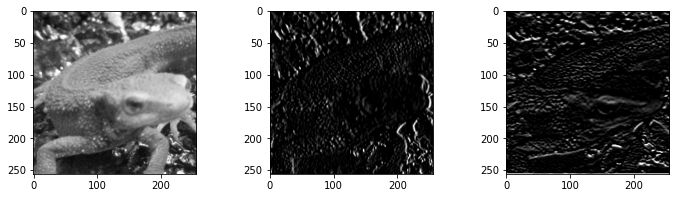

In [369]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.imshow(img_gray, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(prewitt_filter(img_gray, kernel_size=(3, 3)), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(prewitt_filter(img_gray, type='y', kernel_size=(3, 3)), cmap='gray')
plt.show()

## Question 16 ソーベルフィルタ Sobel filter

グレースケール に対して、Sobelフィルタ(3x3)を実装せよ。

Sobelフィルタもエッジを抽出するフィルタであり、次式でそれぞれ定義される。 これはprewittフィルタの中心部分に重みをつけたフィルタである。

![](https://github.com/yoyoyo-yo/Gasyori100knock/raw/master/questions/question_11_20/images/sobel_filter_equ.png)

In [175]:
def gen_sobel_kernel(mode='x', kernel_size=(3, 3)):
    kernel = gen_prewitt_kernel(mode, kernel_size)
    if mode == 'x':
        kernel[kernel_size[0] // 2, 0] = 2
        kernel[kernel_size[0] // 2, -1] = -2
    else:
        kernel[0, kernel_size[1] // 2] = 2
        kernel[-1, kernel_size[1] // 2] = -2
    return kernel

In [364]:
def sobel_filter(img, mode='x', kernel_size=(3, 3)):
    # Padding
    _img = img.copy().astype(np.float32)

    
    h, w = img.shape[0:2]
    kernel_h, kernel_w = kernel_size
    
    top_pad = int(((kernel_h + 1) / 2))
    bottom_pad = top_pad
    left_pad = int(((kernel_w + 1) / 2))
    right_pad = left_pad
    
    if len(_img.shape) == 2:
        _img = np.expand_dims(_img, axis=-1)
    
    _img = np.pad(_img, ((top_pad, bottom_pad), (left_pad, right_pad), (0, 0)))

    out = np.zeros_like(_img)
    new_h, new_w = _img.shape[0:2]
    c = 1 if len(out.shape) == 2 else out.shape[2]
    
    kernel = gen_sobel_kernel(mode, kernel_size)
    
    for i in range(kernel_h // 2, new_h - kernel_h // 2):
        for j in range(kernel_w // 2, new_w - kernel_w // 2):
            for k in range(c):
                out[i, j, k] = np.sum(_img[i - kernel_h//2:i + kernel_h//2 + 1, j - kernel_w//2:j + kernel_w//2 + 1, k] * kernel)

    # normalize (not necessary)
    out -= out.min()
    out /= out.max()
    
    return out[top_pad:top_pad + h, left_pad:left_pad + w]

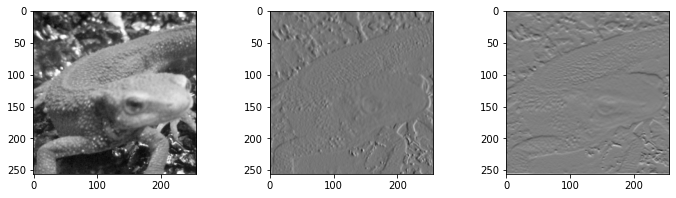

In [365]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.imshow(img_gray, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(sobel_filter(img_gray, kernel_size=(3, 3)), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(sobel_filter(img_gray, mode='y', kernel_size=(3, 3)), cmap='gray')
plt.show()

## Question 17 ラプラシアンフィルタ Laplacian filter

グレースケールに対して、Laplacianフィルタを実装せよ。

Laplacianフィルタとは輝度の二次微分をとることでエッジ検出を行うフィルタである。

![](https://github.com/yoyoyo-yo/Gasyori100knock/raw/master/questions/question_11_20/images/laplacian_filter_equ.png)

In [81]:
def gen_laplacian_kernel():
    kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    return kernel

In [360]:
def laplacian_filter(img, kernel_size=(3, 3)):
    # Padding
    _img = img.copy().astype(np.float32)

    
    h, w = img.shape[0:2]
    kernel_h, kernel_w = kernel_size
    
    top_pad = int(((kernel_h + 1) / 2))
    bottom_pad = top_pad
    left_pad = int(((kernel_w + 1) / 2))
    right_pad = left_pad
    
    if len(_img.shape) == 2:
        _img = np.expand_dims(_img, axis=-1)
    
    _img = np.pad(_img, ((top_pad, bottom_pad), (left_pad, right_pad), (0, 0)))

    out = np.zeros_like(_img)
    new_h, new_w = _img.shape[0:2]
    c = 1 if len(out.shape) == 2 else out.shape[2]
    
    kernel = gen_laplacian_kernel()
    
    for i in range(kernel_h // 2, new_h - kernel_h // 2):
        for j in range(kernel_w // 2, new_w - kernel_w // 2):
            for k in range(c):
                out[i, j, k] = np.sum(_img[i - kernel_h//2:i + kernel_h//2 + 1, j - kernel_w//2:j + kernel_w//2 + 1, k] * kernel)

    # normalize (not necessary)
    out -= out.min()
    out /= out.max()
    
    return out[top_pad:top_pad + h, left_pad:left_pad + w]

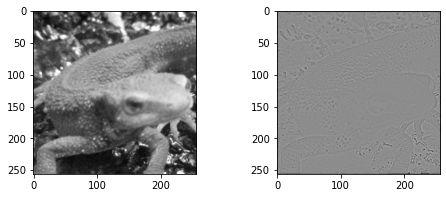

In [361]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(laplacian_filter(img_gray), cmap='gray')

## Question 18 エンボスフィルタ Emboss filter

グレースケールに対して、Embossフィルタを実装せよ。

Embossフィルタとは輪郭部分を浮き出しにするフィルタで、次式で定義される。

![](https://github.com/yoyoyo-yo/Gasyori100knock/raw/master/questions/question_11_20/images/emboss_filter_equ.png)

In [353]:
def gen_emboss_kernel():
    kernel = np.array([[-2, -1, 0], [-1, 1, 1], [0, 1, 2]])
    return kernel

In [356]:
def emboss_filter(img, kernel_size=(3, 3)):
    # Padding
    _img = img.copy().astype(np.float32)

    
    h, w = img.shape[0:2]
    kernel_h, kernel_w = kernel_size
    
    top_pad = int(((kernel_h + 1) / 2))
    bottom_pad = top_pad
    left_pad = int(((kernel_w + 1) / 2))
    right_pad = left_pad
    
    if len(_img.shape) == 2:
        _img = np.expand_dims(_img, axis=-1)
    
    _img = np.pad(_img, ((top_pad, bottom_pad), (left_pad, right_pad), (0, 0)))

    out = np.zeros_like(_img)
    new_h, new_w = _img.shape[0:2]
    c = 1 if len(out.shape) == 2 else out.shape[2]
    
    kernel = gen_emboss_kernel()
    
    for i in range(kernel_h // 2, new_h - kernel_h // 2):
        for j in range(kernel_w // 2, new_w - kernel_w // 2):
            for k in range(c):
                out[i, j, k] = np.sum(_img[i - kernel_h//2:i + kernel_h//2 + 1, j - kernel_w//2:j + kernel_w//2 + 1, k] * kernel)

    # normalize (not necessary)
    out -= out.min()
    out /= out.max()
    
    return out[top_pad:top_pad + h, left_pad:left_pad + w]

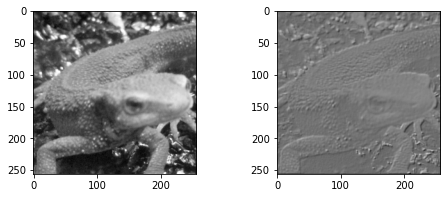

In [357]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(emboss_filter(img_gray), cmap='gray')

## Question 19 LoGフィルタ LoG filter

LoGフィルタ(sigma=3、カーネルサイズ=5)を実装し、imori_noise_256x256.pngのエッジを検出せよ。

LoGフィルタとはLaplacian of Gaussianであり、ガウシアンフィルタで画像を平滑化した後にラプラシアンフィルタで輪郭を取り出すフィルタである。

Laplcianフィルタは二次微分をとるのでノイズが強調されるのを防ぐために、予めGaussianフィルタでノイズを抑える。LoGフィルタは次式で定義される。

![](https://github.com/yoyoyo-yo/Gasyori100knock/raw/master/questions/question_11_20/images/log_filter_equ.png)

In [95]:
def LoG_filter(img, kernel_size=(5, 5), sigma=3):
    img_gau = cv2.GaussianBlur(img, kernel_size, sigma)
    img_lapl = cv2.Laplacian(img_gau, cv2.CV_32F, kernel_size)
    return img_lapl

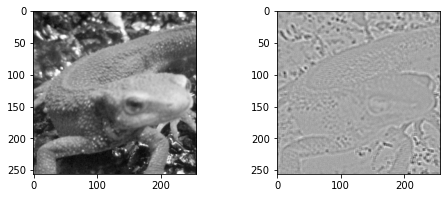

In [96]:
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.imshow(img_gray, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(LoG_filter(img_gray), cmap='gray')

## Question 20 ヒストグラム表示 Histogram

matplotlibを用いてimori_256x256_dark.pngのヒストグラムを表示せよ。

ヒストグラムとは画素の出現回数をグラフにしたものである。 matplotlibではhist()という関数がすでにあるので、それを利用する

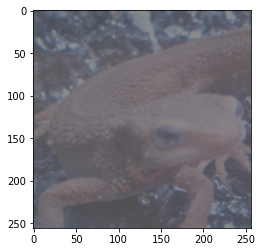

In [6]:
img_dark = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/imori_256x256_dark.png')
plt.imshow(img_dark)

In [16]:
pixels = img_dark.flatten()

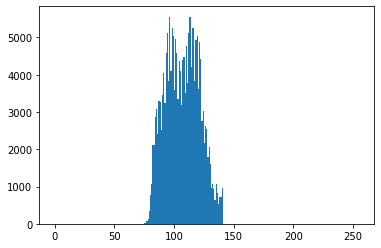

In [24]:
plt.hist(pixels, bins=255, range=(0, 255))
plt.show()

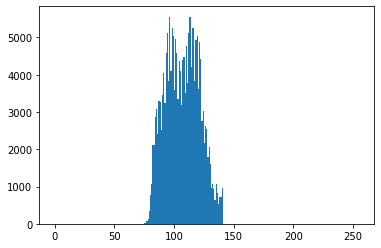

In [25]:
plt.hist(img_dark.ravel(), bins=255, range=(0, 255))
plt.show()

#### `flatten()`と`ravel()`の違い

`ravel()`は可能な限りビューを返すが、`flatten()`は常にコピーを返す